# Comp Screening - cell painting (OG316) GT & CS comparison
## FOR COMPLTETE (datalock) cell painting dataset
#### _BEM 12-06-2021_

### What this does: Compares effects between GT and CS drugs for all 316 drugs in library (OG316)
    - Loads in anndataa files with harmonized dataset containing GT & CS
        - Adds in CS design matrices etc to the anndata files
    - Caculates UMAP and PAGA spaces over the combined dataset to visualize how GT & CS effects compare
        

In [2]:
import os
import sys
import warnings
import random
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import anndata
import multiprocess as mp
from itertools import repeat, chain
from scipy.stats import mode
from scipy.stats import fisher_exact
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.covariance import EmpiricalCovariance
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.multitest import multipletests

pd.set_option('mode.chained_assignment', None)
data_path = '../1_Data/'

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "Helvetica"

## Define Functions

#### GT-CS silhouette scoring

In [3]:
def build_CS_GT_sil_table(adata, drug_clusters, use_rep='X', num_pcs=None):
    
    # select data
    if use_rep == 'X':
        features = adata.X
        
    elif use_rep == 'X_pca':
        if num_pcs == None:
            print('speficy num_pcs')
            return
        else:
            features = adata.obsm['X_pca'][:,0:num_pcs]
            
    elif use_rep == 'X_pca_harmony':
        if num_pcs == None:
            print('speficy num_pcs')
            return
        else:
            features = adata.obsm['X_pca_harmony'][:,0:num_pcs]  
    
    else:
        print('use_rep is not valid option')
        return
    
    # extract cluster labels
    cluster_labels_orig = adata.obs.sig_clusters.astype(str)
    GT_clusters = list(set(cluster_labels_orig)-{'nan','DMSO'})
    
    # iterate through drug groups to calc silhouettes
    sil_GT_clust = np.empty((len(GT_clusters),len(list(drug_clusters.keys()))))
    
    table_col_names = list(drug_clusters.keys())
    i=0
    for key in table_col_names:
        # get position of pools containing drugs from cluster
        design_columns = [item for item in range(len(adata.uns['design_matrix_perturbations'])) if 
                          adata.uns['design_matrix_perturbations'][item] in drug_clusters[key]]

        samples = np.sum(adata.obsm['design_matrix'][:,design_columns], axis=1)>0
        
        # iterate through each GT drug cluster to calc silhouettes
        sil_GT = []
        for GT_cluster in GT_clusters:
            # set pools to match GT_cluster label
            cluster_labels = cluster_labels_orig
            cluster_labels[samples] = GT_cluster
            
            # filter to only GT samples + pool with GT_cluster drugs
            X_labels = cluster_labels[~cluster_labels.isin(['DMSO','nan'])]
            X_features = features[~cluster_labels.isin(['DMSO','nan'])]
            
            # calc silhouettes            
            sample_silhouette_values = silhouette_samples(X_features, X_labels)
            sil_GT.append(np.mean(sample_silhouette_values[X_labels == GT_cluster]))
        
        sil_GT_clust[:,i] = np.array(sil_GT)
        
        i+=1
    
    return pd.DataFrame(sil_GT_clust, columns=table_col_names, index=GT_clusters)
    
    

## Analysis

### Load in anndata

In [14]:
# PCA harmony data
OG316 = anndata.read_h5ad('OG316_analyzed_anndata.h5ad')

# correct the Metdata_compression to reflect true GT #
OG316.obs.Metadata_compression = OG316.obs.Metadata_compression*3
OG316.obs.loc[OG316.obs.Metadata_compression==3,'Metadata_compression'] = 1

#filter OG316 to only 'random' compressed runs
OG316 = OG316[~OG316.obs.Metadata_perturbation.isin(['mahalanobis','phenograph_all','weighted_cosine']),:]

### Remove landmarks from compressed runs
CSs = ['CS_run1', 'CS_run2', 'CS_run3']
LMs = ['Doxorubicin','Daunorubicin','Fluvastatin','Ticlopidine',
       'Tropicamide','Mycophenolic Acid','Vinblastine Sulfate','Riluzole']

OG316 = OG316[~(OG316.obs.Metadata_run.isin(CSs)&OG316.obs.Metadata_perturbation.isin(LMs)),:]

In [15]:
### Remove non-sig samples from GT runs
# load table of significant perturbation groups (from GT)
GT316_clusters = pd.read_csv('GT316_drug_clusters.csv',index_col=0).\
                 groupby('leiden')['Metadata_perturbation'].apply(list).to_dict()

OG316 = OG316[~(~OG316.obs.Metadata_run.isin(CSs)&OG316.obs.sig_clusters.isna()),:]

In [16]:
# add design matrix to OG316
# load and combine
run1_design = pd.read_csv(data_path+'CS_run1_PCH_rd_OG316_design_matrix.csv',index_col=0).reset_index().rename(columns={'index':'design_index'})
run2_design = pd.read_csv(data_path+'CS_run2_PCH_rd_OG316_design_matrix.csv',index_col=0).reset_index().rename(columns={'index':'design_index'})
run3_design = pd.read_csv(data_path+'CS_run3_PCH_rd_OG316_design_matrix.csv',index_col=0).reset_index().rename(columns={'index':'design_index'})

design_table = pd.concat([run1_design,run2_design,run3_design])
design_index=OG316.obs.Metadata_Plate.astype(str)+'_'+OG316.obs.Metadata_Well.astype(str)

# build
design_mat = pd.DataFrame(design_index, columns=['design_index']).\
             merge(design_table,how='left',on='design_index').\
             drop(['design_index'],axis=1)

# add
OG316.obsm['design_matrix']=np.array(design_mat)
OG316.uns['design_matrix_perturbations'] = design_mat.columns.values.tolist()

In [17]:
# subsample each compression level such that n_obs <= n_obs GT
GT_cells = list(OG316[OG316.obs.Metadata_compression==1].obs.index)
GT_cells_n = len(GT_cells)

# n_obs > n_obs GT
CS_6_cells = list(sc.pp.subsample(OG316[OG316.obs.Metadata_compression==6], n_obs=GT_cells_n, copy=True).obs.index)
CS_12_cells = list(sc.pp.subsample(OG316[OG316.obs.Metadata_compression==12], n_obs=GT_cells_n, copy=True).obs.index)

# n_obs < n_obs GT
CS_other_cells = list(OG316[OG316.obs.Metadata_compression>=24].obs.index)

# recombine
indicies = GT_cells+CS_6_cells+CS_12_cells+CS_other_cells

OG316 = OG316[OG316.obs.index.isin(indicies),:]

### Determine num_PCs, neighbors, UMAP

In [18]:
# recalc PC's for dataset
sc.pp.pca(OG316)

# single plate (no need to batch correct)
sc.external.pp.harmony_integrate(OG316, 'Metadata_run')

# get num of PCs to use (up to 90% var explained)
num_pcs = sum(np.cumsum(OG316.uns['pca']['variance_ratio']) < 0.9)+1
print('90% of variance explained by '+str(num_pcs)+' PCs')

2021-12-14 12:39:00,035 - harmonypy - INFO - Iteration 1 of 10
2021-12-14 12:39:00,358 - harmonypy - INFO - Iteration 2 of 10
2021-12-14 12:39:00,665 - harmonypy - INFO - Iteration 3 of 10
2021-12-14 12:39:00,991 - harmonypy - INFO - Iteration 4 of 10
2021-12-14 12:39:01,267 - harmonypy - INFO - Iteration 5 of 10
2021-12-14 12:39:01,513 - harmonypy - INFO - Iteration 6 of 10
2021-12-14 12:39:01,675 - harmonypy - INFO - Iteration 7 of 10
2021-12-14 12:39:01,931 - harmonypy - INFO - Iteration 8 of 10
2021-12-14 12:39:02,091 - harmonypy - INFO - Iteration 9 of 10
2021-12-14 12:39:02,242 - harmonypy - INFO - Iteration 10 of 10
2021-12-14 12:39:02,384 - harmonypy - INFO - Converged after 10 iterations


90% of variance explained by 14 PCs


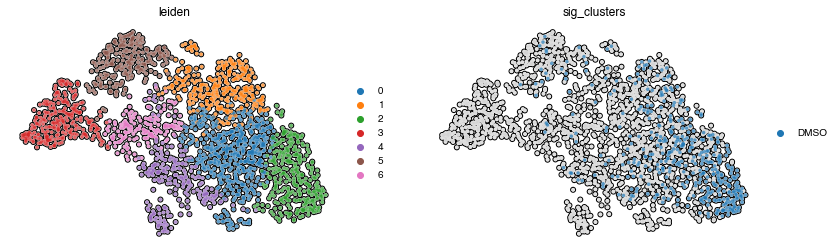

In [19]:
# cluster the CS-only samples
CS316 = OG316[OG316.obs.Metadata_run.isin(CSs),:]

sc.pp.neighbors(CS316, n_neighbors=int(np.round(0.5*np.sqrt(np.shape(CS316.X)[0]))), 
                n_pcs=num_pcs, use_rep = 'X_pca_harmony')
sc.tl.umap(CS316)

sc.tl.leiden(CS316, resolution = 0.4)

sc.pl.umap(CS316, 
           color=['leiden','sig_clusters'], add_outline=True,
           frameon=False, size=50, na_in_legend=False)

In [20]:
# Add CS-only clustering back to merged dataset
CS_clusters = ['CS_']+CS316.obs.leiden.astype(str)
GT_clusters= OG316.obs.sig_clusters.astype(str)
GT_clusters[GT_clusters=='nan'] = CS_clusters[GT_clusters=='nan']

OG316.obs.sig_clusters = GT_clusters.astype('category')

In [23]:
new_cluster_order = ['DMSO', '2-lo', '2-hi', '3',
                     '4', '5', '6',
                     '6-8','7-lo','7-hi', '8',
                     'CS_0','CS_1','CS_2','CS_3','CS_4',
                     'CS_5','CS_6']

OG316.obs.sig_clusters = OG316.obs.sig_clusters.values.reorder_categories(new_cluster_order)

# From GT
drug_cluster_colors = ['#EFAD81','#EF6F18',
                       '#844E27','#6153A3','#C5E2BC','#437548',
                       '#8F9E35',
                       '#7AC4B9','#12544D',
                       '#CCA754']

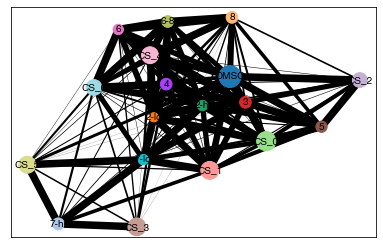

In [24]:
sc.pp.neighbors(OG316, n_neighbors=int(np.round(0.5*np.sqrt(np.shape(OG316.X)[0]))), 
                n_pcs=num_pcs, use_rep = 'X_pca_harmony')
sc.tl.paga(OG316, groups='sig_clusters')
sc.pl.paga(OG316, color=['sig_clusters'])
sc.tl.umap(OG316, init_pos='paga')

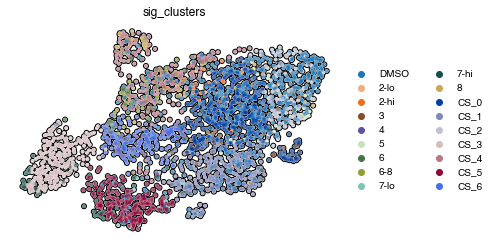

In [25]:


sc.pl.umap(OG316, 
           color=['sig_clusters'], add_outline=True,
           frameon=False, size=50,
           palette=['tab:blue']+drug_cluster_colors+sc.pl.palettes.zeileis_28[0:8])

### Look @ where Compressed Screens are

In [26]:
OG316.obs.Metadata_compression = OG316.obs.Metadata_compression.astype(int).astype(str).astype('category')

new_cluster_order = ['1', '6', '12',
                     '24', '48', '96']

OG316.obs.Metadata_compression = OG316.obs.Metadata_compression.values.reorder_categories(new_cluster_order)
sc.tl.embedding_density(OG316, basis='umap', groupby='Metadata_compression')

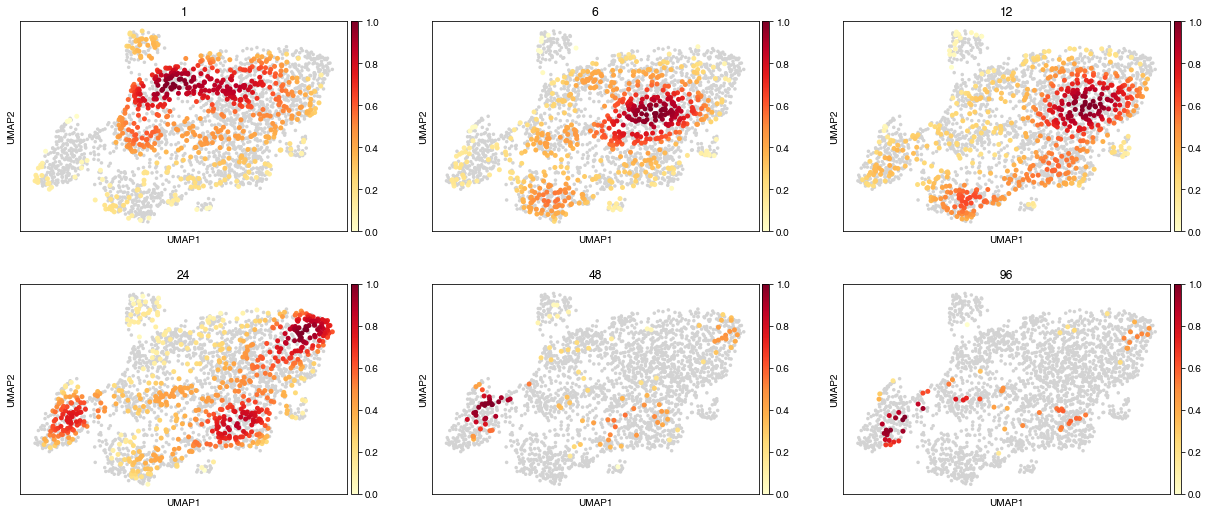

In [27]:
sc.pl.embedding_density(OG316, ncols=3, basis='umap', key='umap_density_Metadata_compression',
                        bg_dotsize=50,
                        fg_dotsize=100,
                        save='GT+CS_compression_density.pdf')

### Map compressed data to GT 

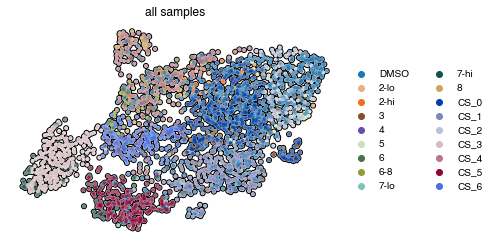

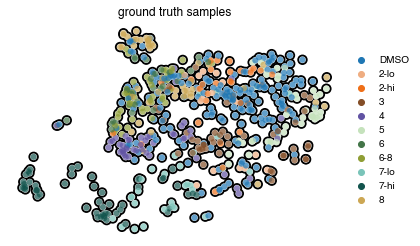

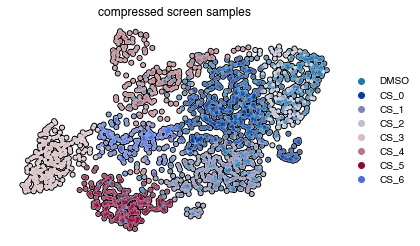

In [34]:
sc.pl.umap(OG316, 
           color='sig_clusters', add_outline=True,
           frameon=False, size=50, na_in_legend=False,
           title='all samples')

sc.pl.umap(OG316[OG316.obs.Metadata_compression=='1',:], 
           color='sig_clusters', add_outline=True,
           frameon=False, size=150, na_in_legend=False,
           title='ground truth samples',
           save='GT+CS_GT-only.pdf')

sc.pl.umap(OG316[OG316.obs.Metadata_compression!='1',:], 
           color='sig_clusters', add_outline=True,
           frameon=False, size=50, na_in_legend=False,
           title='compressed screen samples',
           save='GT+CS_CS-only.pdf')

### Try out PAGA

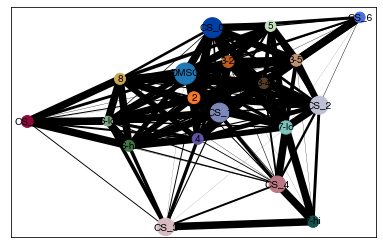

In [93]:
sc.tl.paga(OG316, groups='sig_clusters')
sc.pl.paga(OG316, color=['sig_clusters'])

In [94]:
sc.tl.umap(OG316, init_pos='paga')

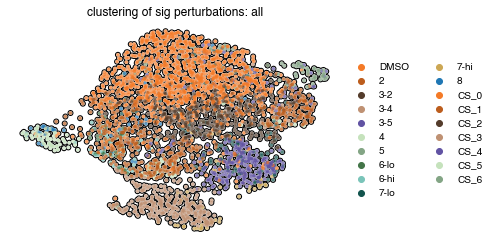

Trying to set attribute `.uns` of view, copying.


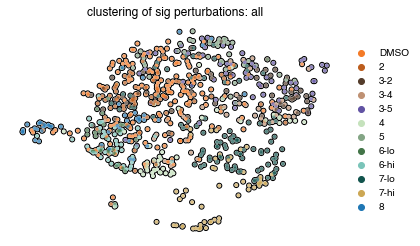

In [97]:
sc.pl.umap(OG316, 
           color='sig_clusters', add_outline=True,
           frameon=False, size=50, na_in_legend=False,
           title='clustering of sig perturbations: all', 
           palette=drug_cluster_colors+['tab:blue'])

sc.pl.umap(OG316[OG316.obs.Metadata_compression=='1',:], 
           color='sig_clusters', add_outline=True,
           frameon=False, size=50, na_in_legend=False,
           title='clustering of sig perturbations: all', 
           palette=drug_cluster_colors+['tab:blue'])

In [243]:
sc.tl.leiden(OG316, resolution = 0.75)

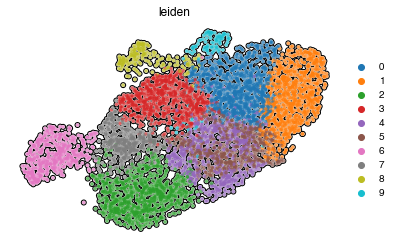

In [244]:
sc.pl.umap(OG316, 
           color='leiden', add_outline=True,
           frameon=False, size=50, na_in_legend=False)

In [245]:
sc.tl.paga(OG316, groups='leiden')

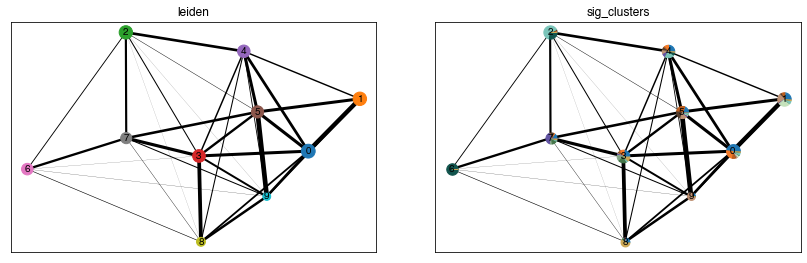

In [246]:
OG_plot = OG316[OG316.obs.Metadata_compression=='1.0',:]
OG_plot = OG_plot[~OG_plot.obs.sig_clusters.isna()]


sc.pl.paga(OG_plot, color=['leiden', 'sig_clusters'])

In [247]:
sc.tl.umap(OG316, init_pos='paga')
sc.tl.umap(OG_plot, init_pos='paga')

Trying to set attribute `.uns` of view, copying.


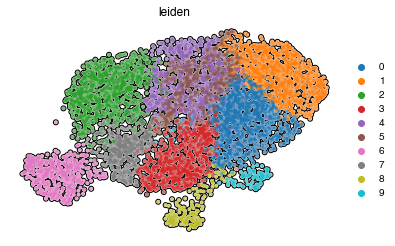

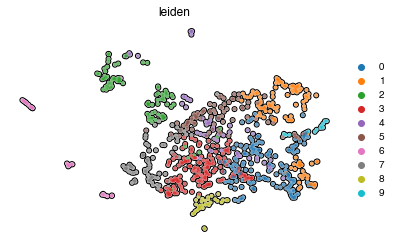

In [248]:
sc.pl.umap(OG316, 
           color='leiden', add_outline=True,
           frameon=False, size=50, na_in_legend=False)

sc.pl.umap(OG_plot, 
           color='leiden', add_outline=True,
           frameon=False, size=50, na_in_legend=False)

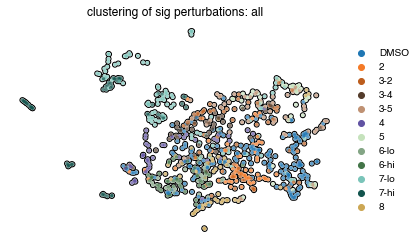

In [249]:
sc.pl.umap(OG_plot, 
           color='sig_clusters', add_outline=True,
           frameon=False, size=50, na_in_legend=False,
           title='clustering of sig perturbations: all', 
           palette=['tab:blue']+drug_cluster_colors)

